A predictive model that answers the question: “what sorts of people were more likely to survive?” using passenger data (ie name, age, gender, socio-economic class, etc).

Goal
It is your job to predict if a passenger survived the sinking of the Titanic or not.
For each in the test set, you must predict a 0 or 1 value for the variable.



Imports

In [72]:
%matplotlib inline  
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
import warnings
warnings.filterwarnings("ignore")

Exploratory Data Analysis (EDA) 

=== First 5 rows of training data ===


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S



=== Summary statistics ===


,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200



=== Dataset info ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB

=== Missing values per column ===


PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

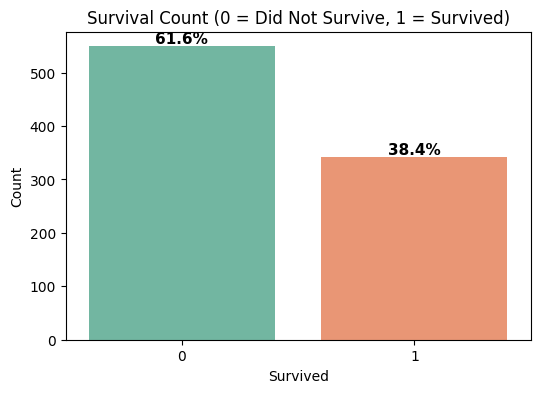


=== Survival percentage ===
Survived
0    61.616162
1    38.383838
Name: proportion, dtype: float64

=== Survival by Gender ===


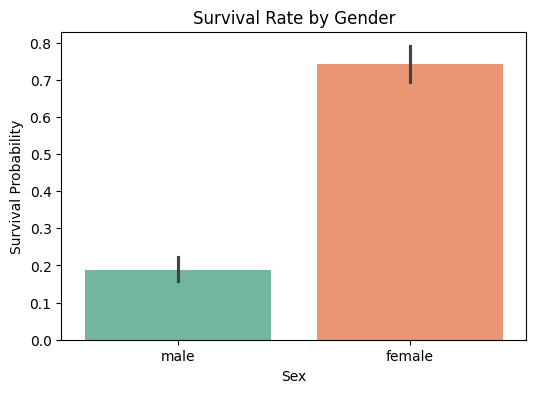


=== Survival by Ticket Class ===


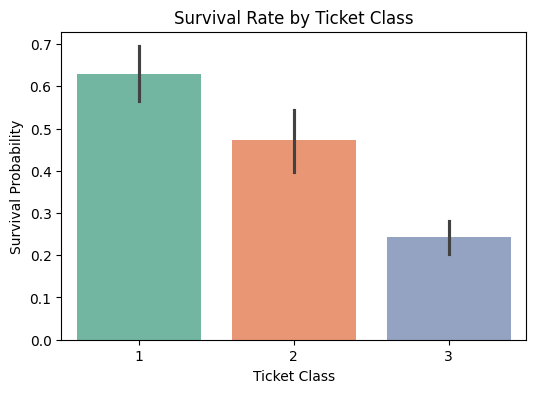


=== Survival by Embarked Port ===


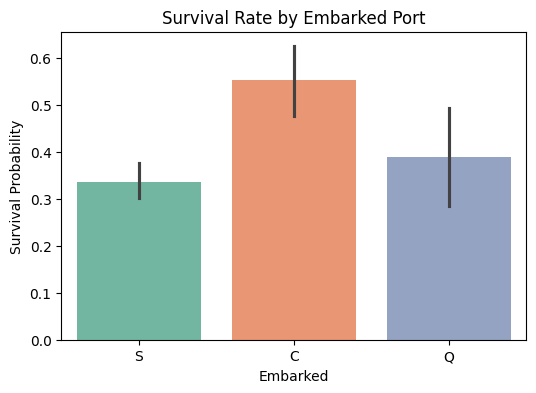


=== Survival by Family Size ===


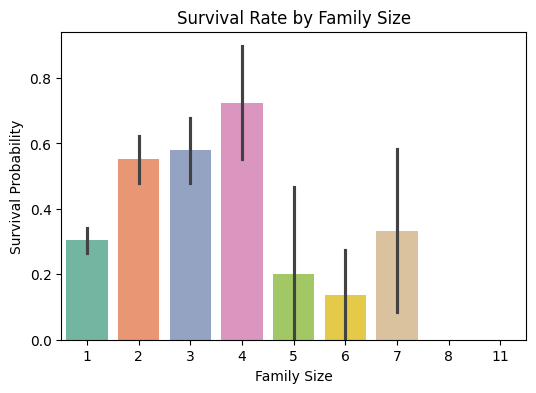


=== Survival by Name Title ===


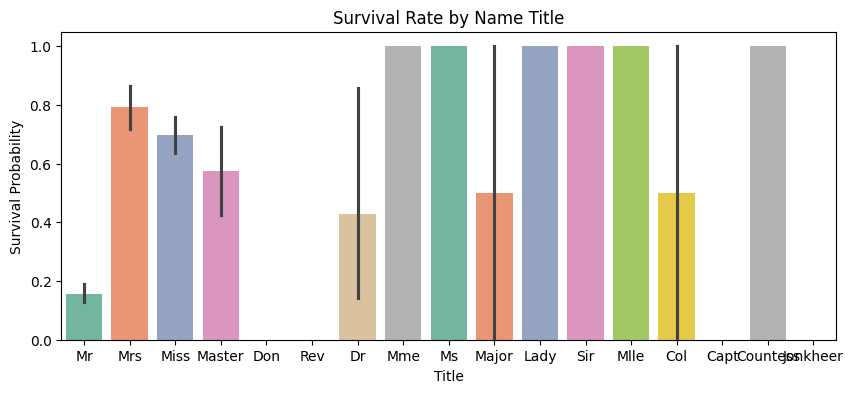


=== Survival by Age Group ===


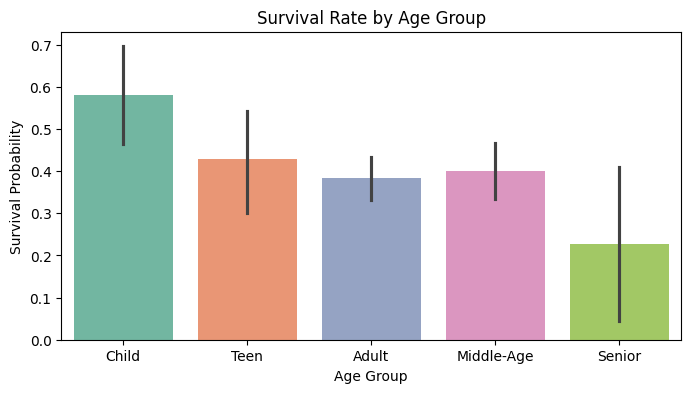


=== Survival by Age Distribution ===


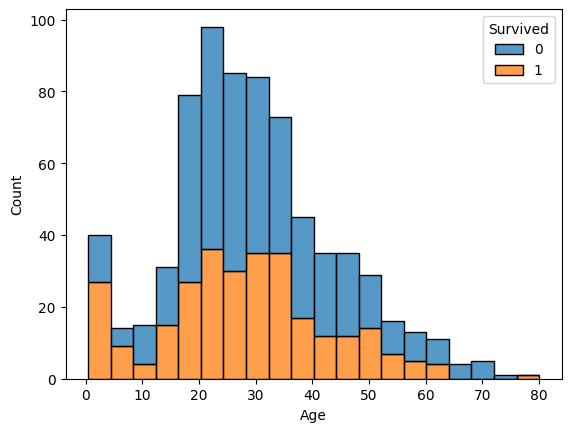


=== Survival by Age Distribution (KDE) ===


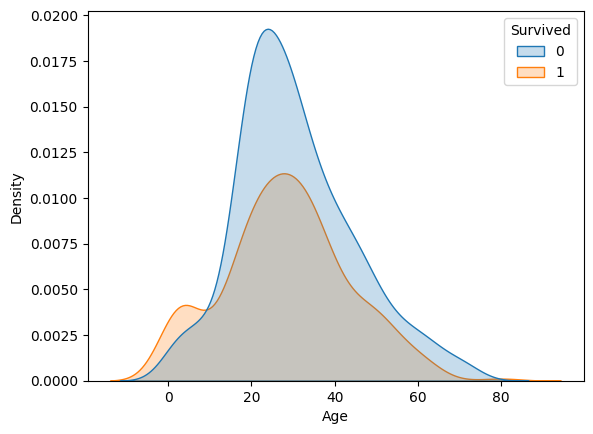

In [94]:

train_df = pd.read_csv('data/train.csv')
test_df = pd.read_csv('data/test.csv')

print("=== First 5 rows of training data ===")
display(train_df.head())

print("\n=== Summary statistics ===")
display(train_df.describe())

print("\n=== Dataset info ===")
train_df.info()

print("\n=== Missing values per column ===")
display(train_df.isna().sum())

# Countplot for class imbalance
plt.figure(figsize=(6,4))
ax = sns.countplot(data=train_df, x="Survived", palette="Set2")

# Annotate percentages on top of bars
total = len(train_df)
for p in ax.patches:
    height = p.get_height()
    percentage = f'{100 * height / total:.1f}%'
    ax.annotate(percentage, (p.get_x() + p.get_width() / 2, height),
                ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.title("Survival Count (0 = Did Not Survive, 1 = Survived)")
plt.xlabel("Survived")
plt.ylabel("Count")
plt.show()

print("\n=== Survival percentage ===")
print(train_df['Survived'].value_counts(normalize=True) * 100)

### Visualizations ###

# Survival by Gender
print("\n=== Survival by Gender ===")
plt.figure(figsize=(6,4))
sns.barplot(x="Sex", y="Survived", data=train_df, palette="Set2")
plt.title("Survival Rate by Gender")
plt.ylabel("Survival Probability")
plt.show()

# Survival by Ticket Class
print("\n=== Survival by Ticket Class ===")
plt.figure(figsize=(6,4))
ax = sns.barplot(x="Pclass", y="Survived", data=train_df, palette="Set2")  
ax.set(
    title="Survival Rate by Ticket Class",
    xlabel="Ticket Class",
    ylabel="Survival Probability"
)
plt.show()

# Survival by Embarked
print("\n=== Survival by Embarked Port ===")
plt.figure(figsize=(6,4))
ax = sns.barplot(x='Embarked', y='Survived', data=train_df, palette='Set2')
ax.set(title="Survival Rate by Embarked Port", xlabel="Embarked", ylabel="Survival Probability")
plt.show()

# Survival by family size
print("\n=== Survival by Family Size ===")
train_df['FamilySize'] = train_df['SibSp'] + train_df['Parch'] + 1  
plt.figure(figsize=(6,4))
ax = sns.barplot(x='FamilySize', y='Survived', data=train_df, palette='Set2')
ax.set(title="Survival Rate by Family Size", xlabel="Family Size", ylabel="Survival Probability")
plt.show()

#Survival by Name Title
print("\n=== Survival by Name Title ===")
train_df['Title'] = train_df['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
plt.figure(figsize=(10,4))
ax = sns.barplot(x='Title', y='Survived', data=train_df, palette='Set2')
ax.set(title="Survival Rate by Name Title", xlabel="Title", ylabel="Survival Probability")
plt.show()


#### trying different ways to visualize age distribution ####
# Survival by Age Distribution _1 (with grouped ages)
print("\n=== Survival by Age Group ===")
train_df['AgeGroup'] = pd.cut(train_df['Age'], bins=[0, 12, 18, 35, 60, 80],
                              labels=['Child','Teen','Adult','Middle-Age','Senior'])

plt.figure(figsize=(8,4))
ax = sns.barplot(x='AgeGroup', y='Survived', data=train_df, palette='Set2')
ax.set(title="Survival Rate by Age Group", xlabel="Age Group", ylabel="Survival Probability")
plt.show()

# Survival by Age Distribution _2 (with continuous ages)
print("\n=== Survival by Age Distribution ===")
sns.histplot(data=train_df, x='Age', hue='Survived', multiple='stack')
plt.show()

# Survival by Age Distribution _3 (with KDE)
print("\n=== Survival by Age Distribution (KDE) ===")
sns.kdeplot(data=train_df, x='Age', hue='Survived', fill=True)
plt.show()


Data Preprocessing

In [74]:
### Data Preprocessing and Feature Engineering ###

class FeatureEngineer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        #X = X.copy()
        
        X["FamilySize"] = X["SibSp"] + X["Parch"] + 1
        X["Title"] = X["Name"].str.extract(r" ([A-Za-z]+)\.", expand=False)
 
        X["Deck"] = X["Cabin"].str[0]  
        X["Deck"] = X["Deck"].fillna("Unknown")  
        
        X = X.drop(columns=["PassengerId", "Ticket", "Cabin", "Name"])
        
        return X

    
  

numeric_features = ["Age", "Fare", "SibSp", "Parch", "FamilySize"]
categorical_features = ["Sex", "Embarked", "Pclass", "Title", "Deck"]

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')), 
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)


full_pipeline = Pipeline(steps=[
    ("feature_engineering", FeatureEngineer()),
    ("preprocessor", preprocessor)
])

X_train = train_df.drop(columns=["Survived"])  
y_train = train_df["Survived"]

X_train_processed = full_pipeline.fit_transform(X_train)
print("Train data transformed shape:", X_train_processed.shape)

X_test_processed = full_pipeline.transform(test_df)  
print("Test data transformed shape:", X_test_processed.shape)


Train data transformed shape: (891, 39)
Test data transformed shape: (418, 39)


Model Building

In [76]:
### Model Training and Hyperparameter Tuning ###

classification_models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=200, random_state=42),
    "SVM (Linear)": SVC(kernel="linear", probability=True),
    "SVM (RBF)": SVC(kernel="rbf", probability=True),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42)
}

classification_results = {}


for model_name, model in classification_models.items():
    cv_scores = cross_val_score(model, X_train_processed, y_train, cv=5, scoring="accuracy")
    
    classification_results[model_name] = np.mean(cv_scores)
    
    
# Hyperparameter tuning (example: Logistic Regression)
log_reg_grid = {
    "C": np.logspace(-4, 4, 20), "solver": ["liblinear"]}

rs_log_reg = RandomizedSearchCV(
    estimator=LogisticRegression(max_iter=1000),
    param_distributions=log_reg_grid,
    n_iter=5,
    cv=5,
    verbose=1
)

rs_log_reg.fit(X_train_processed, y_train)

classification_results["Logistic Regression"] = rs_log_reg.best_score_

for model_name, score in classification_results.items():
    print(f"{model_name}: {score:.4f}")



Fitting 5 folds for each of 5 candidates, totalling 25 fits
Logistic Regression: 0.8249
Random Forest: 0.8013
SVM (Linear): 0.8238
SVM (RBF): 0.8339
Gradient Boosting: 0.8272
XGBoost: 0.8283


=== Model Comparison ===
                 Model  Accuracy
0            SVM (RBF)  0.833877
1              XGBoost  0.828272
2    Gradient Boosting  0.827167
3  Logistic Regression  0.824920
4         SVM (Linear)  0.823784
5        Random Forest  0.801350


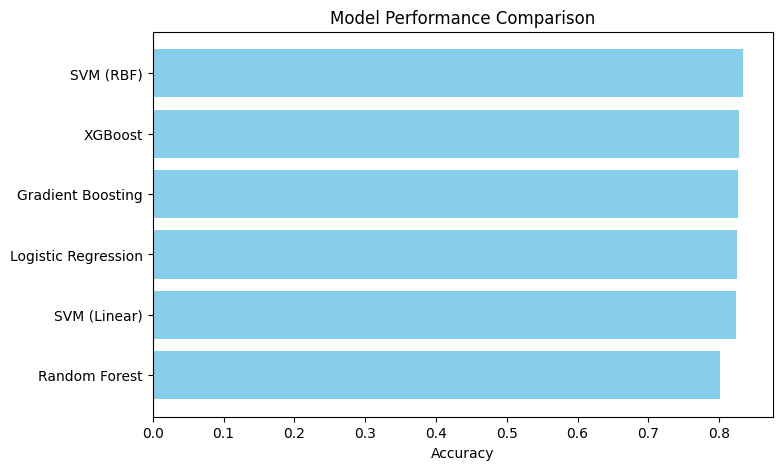

In [77]:
# Model comparison#

results_df = pd.DataFrame(list(classification_results.items()), 
                          columns=["Model", "Accuracy"])

results_df = results_df.sort_values(by="Accuracy", ascending=False).reset_index(drop=True)

print("=== Model Comparison ===")
print(results_df)

plt.figure(figsize=(8,5))
plt.barh(results_df["Model"], results_df["Accuracy"], color="skyblue")
plt.xlabel("Accuracy")
plt.title("Model Performance Comparison")
plt.gca().invert_yaxis()  # Best model at top
plt.show()


Evaluation

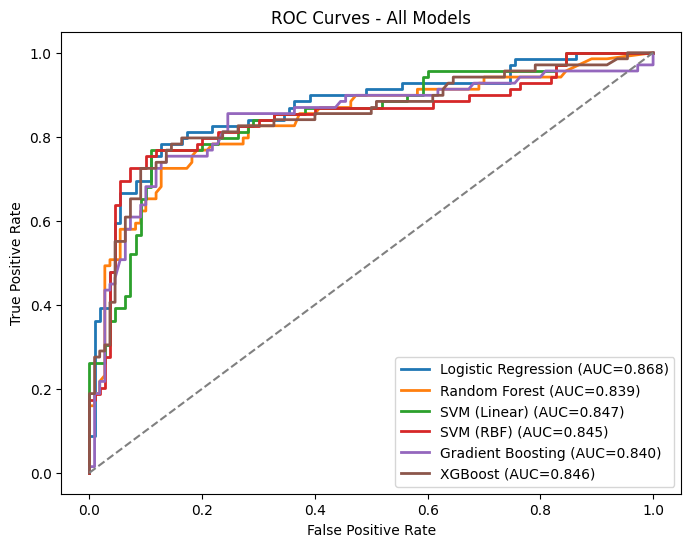


Model Comparison Metrics:
                     Accuracy  Precision  Recall      F1  ROC-AUC
Logistic Regression    0.8324     0.8095  0.7391  0.7727   0.8680
Random Forest          0.8045     0.7576  0.7246  0.7407   0.8385
SVM (Linear)           0.8268     0.7794  0.7681  0.7737   0.8472
SVM (RBF)              0.8380     0.8125  0.7536  0.7820   0.8447
Gradient Boosting      0.8156     0.8103  0.6812  0.7402   0.8396
XGBoost                0.8212     0.7761  0.7536  0.7647   0.8464


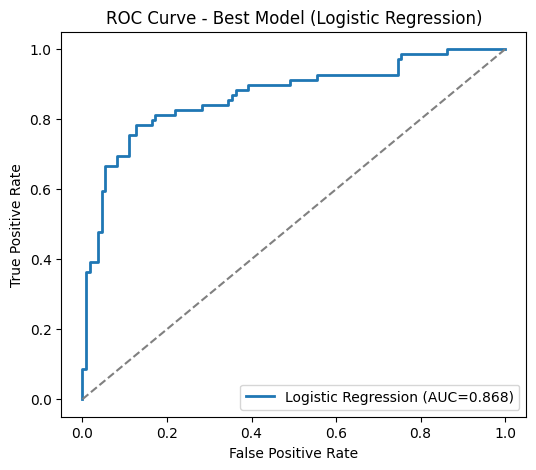

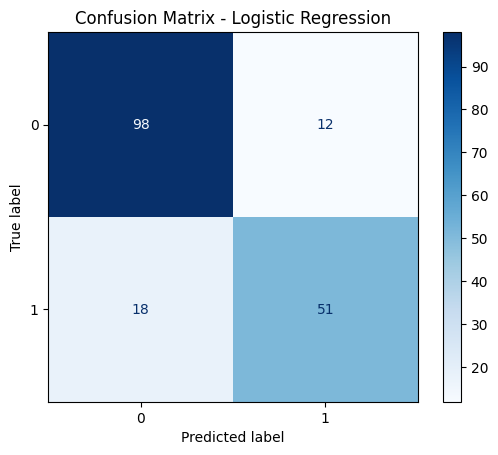


Best model selected: Logistic Regression
Accuracy     0.8324
Precision    0.8095
Recall       0.7391
F1           0.7727
ROC-AUC      0.8680
Name: Logistic Regression, dtype: float64


In [ ]:
# Evaluation (Comparison + Final Best Model)

# === Train/Validation Split ==
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_train_processed, y_train, test_size=0.2, random_state=42, stratify=y_train
)

# Step 1: Compare all models
metrics_summary = {}

plt.figure(figsize=(8,6))

for model_name, model in classification_models.items():
    model.fit(X_train_split, y_train_split)
    y_pred = model.predict(X_val_split)
    y_pred_proba = model.predict_proba(X_val_split)[:, 1] if hasattr(model, "predict_proba") else None
    
    # Save metrics
    metrics_summary[model_name] = {
        "Accuracy": accuracy_score(y_val_split, y_pred),
        "Precision": precision_score(y_val_split, y_pred),
        "Recall": recall_score(y_val_split, y_pred),
        "F1": f1_score(y_val_split, y_pred),
        "ROC-AUC": roc_auc_score(y_val_split, y_pred_proba) if y_pred_proba is not None else None
    }
    
    # ROC Curve (only if probas available)
    if y_pred_proba is not None:
        fpr, tpr, _ = roc_curve(y_val_split, y_pred_proba)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=f"{model_name} (AUC={roc_auc:.3f})")

# --- Plot comparison ROC ---
plt.plot([0, 1], [0, 1], color="gray", linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves - All Models")
plt.legend(loc="lower right")
plt.show()

# --- Metrics Table ---
metrics_df = pd.DataFrame(metrics_summary).T
print("\nModel Comparison Metrics:")
print(metrics_df.round(4))

# --- Step 2: Evaluate Best Model ---
best_model_name = metrics_df['ROC-AUC'].idxmax()  # pick by ROC-AUC (or F1 if you prefer)
best_model = classification_models[best_model_name]

best_model.fit(X_train_split, y_train_split)
y_pred = best_model.predict(X_val_split)
y_pred_proba = best_model.predict_proba(X_val_split)[:, 1] if hasattr(best_model, "predict_proba") else None

# Single ROC curve for best model
if y_pred_proba is not None:
    fpr, tpr, _ = roc_curve(y_val_split, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(6,5))
    plt.plot(fpr, tpr, lw=2, label=f"{best_model_name} (AUC={roc_auc:.3f})")
    plt.plot([0, 1], [0, 1], color="gray", linestyle="--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve - Best Model ({best_model_name})")
    plt.legend(loc="lower right")
    plt.show()

# Confusion Matrix
cm = confusion_matrix(y_val_split, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.classes_)
disp.plot(cmap="Blues")
plt.title(f"Confusion Matrix - {best_model_name}")
plt.show()

print(f"\nBest model selected: {best_model_name}")
print(metrics_df.loc[best_model_name].round(4))


In [92]:
# ==== Final Prediction on Test Set ====

test_predictions = best_model.predict(X_test_processed)
submission_df = pd.DataFrame({
    'PassengerId': test_df['PassengerId'],
    'Survived': test_predictions
})
submission_file = "titanic_submission.csv"
submission_df.to_csv(submission_file, index=False)
print(f"Submission file saved: {submission_file}")
submission_df.head()

Submission file saved: titanic_submission.csv


,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
